In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import scipy
import statsmodels.api as sm

In [2]:
variables = ['e_gleam_mm_mon','glws2_gwater_mm','grace_lwe_cm','grun_ens_runoff_mm_day','prec_fldas_mm_day','smroot_gleam_mm3_mm3','smsurf_gleam_mm3_mm3','lai_gimms4g_m2_m2']
variable2s = ['e_gleam_mm_mon','glws2_gwater_mm','grace_lwe_cm','grun_ens_runoff_mm_day','prec_fldas_mm_day','smroot_gleam_mm3_mm3','smsurf_gleam_mm3_mm3','lai_gimms4g_m2_m2']
basins = ['LIMPOPO','ORANGE','NILE','JUBBA (also GENALE WENZ)']


bName=[];v1=[];v2=[];vcc=[]
for basin in basins:
    for variable in variables:
        for variable2 in variable2s:
            #read basin dataframe
            path = './Basin_data/'+variable+'_'+basin+'.csv'
            path2 = './Basin_data/'+variable2+'_'+basin+'.csv'

            bDF = pd.read_csv(path)
            bDF2 = pd.read_csv(path2)
 
            #plot climatology
            plt.figure()
            bDF.iloc[:,1:].mean(0).plot(title='Climatology of '+variable+'\nin '+basin+' basin')
            plt.savefig('./Figures/Climatologies/'+variable+'_'+basin+'.png')
            plt.close()

            #Calculate anomalies by remove monthly climatology from each month
            bDF.iloc[:,1:] = bDF.iloc[:,1:] - bDF.iloc[:,1:].mean(0)
            bDF2.iloc[:,1:] = bDF2.iloc[:,1:] - bDF2.iloc[:,1:].mean(0)
            #reshape the data
            bDF = bDF.melt(id_vars='Year',var_name='Month')
            bDF2 = bDF2.melt(id_vars='Year',var_name='Month')
            #create a datetime index
            dtInd = pd.to_datetime(bDF.Year.astype(int).astype(str) + bDF['Month'], format='%Y%b')
            bDF['date'] = dtInd
            dtInd2 = pd.to_datetime(bDF2.Year.astype(int).astype(str) + bDF2['Month'], format='%Y%b')
            bDF2['date'] = dtInd2
            bDF=bDF.set_index('date')
            bDF2=bDF2.set_index('date')
            
            if variable=='grace_lwe_cm':
                bDF.value.interpolate(method='linear',inplace=True,limit=3)
                dtInd = dtInd[(dtInd.dt.year<=2016)&(dtInd.dt.year>2002)]
            if variable2=='grace_lwe_cm':
                bDF2.value.interpolate(method='linear',inplace=True,limit=3)
                dtInd2 = dtInd2[(dtInd2.dt.year<=2016)&(dtInd2.dt.year>2002)]

            #choose only values that exist in both datasets to calculate the cross correlation
            dts = set(dtInd).intersection(dtInd2)
            bDF=bDF.loc[dts]
            bDF2=bDF2.loc[dts]

            #reorder the data chronologically
            bDF = bDF.sort_values(by='date')
            bDF2 = bDF2.sort_values(by='date')

            #Calculate the autocorrelation
            if variable == variable2:
                anoms = bDF.value.values
                anoms = anoms-np.nanmean(anoms)
                std = np.std(anoms)
                corr = sm.tsa.stattools.ccf(anoms/std,anoms/std,adjusted=True)
                plt.figure()
                plt.plot(corr[:9])
                plt.title(variable+' autocorrelation out to 9 months')
                plt.savefig('./Figures/crosscorrelations_individual_vars/'+variable+'_'+basin+'.png')
                plt.close()
            else:
                anoms = bDF.value.values
                anoms2 = bDF2.value.values
                anoms = anoms-np.nanmean(anoms)
                anoms2 = anoms2-np.nanmean(anoms2)
                std = np.std(anoms)
                std2 = np.std(anoms2)
                corr = sm.tsa.stattools.ccf(anoms/std,anoms2/std2,adjusted=True)
                plt.figure()
                plt.plot(corr[:9])
                plt.title(variable+' lags \n'+variable2+'\ncross-correlation out to 9 months')
                plt.savefig('./Figures/crosscorrelations_individual_vars/'+variable+'_'+variable2+'_'+basin+'.png')
                plt.close()
                
            vcc = np.append(vcc,corr[:9],0)
            v1 = np.append(v1,np.repeat(variable,9),0)
            v2 = np.append(v2,np.repeat(variable2,9),0)
            bName = np.append(bName,np.repeat(basin,9),0)
            
df =pd.DataFrame(data={'basin':bName,'var1':v1,'var2':v2,'cross_corr':vcc})
path = './crosscorr_dfs/basin_cc.pkl'
df.to_pickle(path)

/var/folders/pk/_ym78shs7tx06w00zbcwxwgc0000gp/T/ipykernel_47261/3826487057.py:46: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  bDF=bDF.loc[dts]
/var/folders/pk/_ym78shs7tx06w00zbcwxwgc0000gp/T/ipykernel_47261/3826487057.py:47: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  bDF2=bDF2.loc[dts]
/var/folders/pk/_ym78shs7tx06w00zbcwxwgc0000gp/T/ipykernel_47261/3826487057.py:46: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  bDF=bDF.loc[dts]
/var/folders/pk/_ym78shs7tx06w00zbcwxwgc0000gp/T/ipykernel_47261/3826487057.py:47: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  bDF2=bDF2.loc[dts]
/var/folders/pk/_ym78shs7tx06w00zbcwxwgc0000gp/T/ipykernel_47261/3826487057.py:46: FutureWarning: Passing a set as an indexer is depreca

/var/folders/pk/_ym78shs7tx06w00zbcwxwgc0000gp/T/ipykernel_47261/1939517609.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


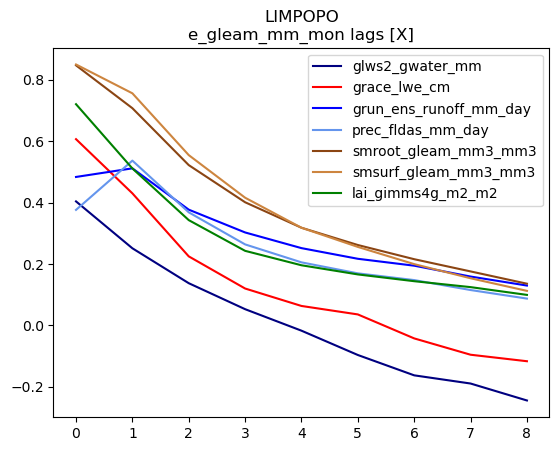

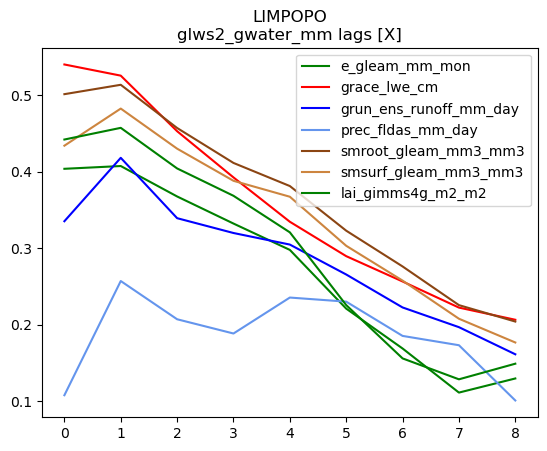

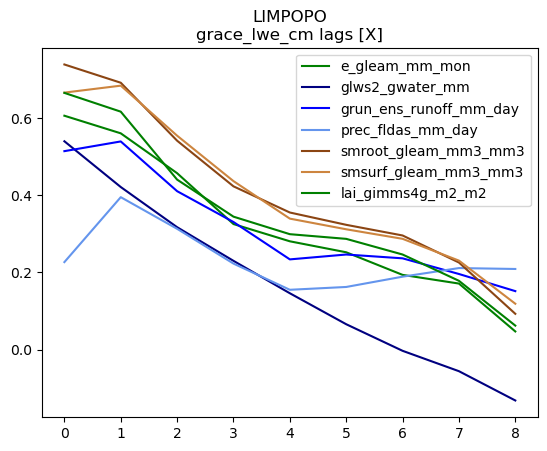

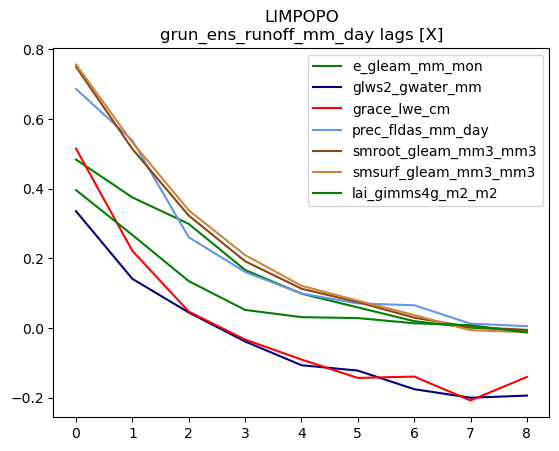

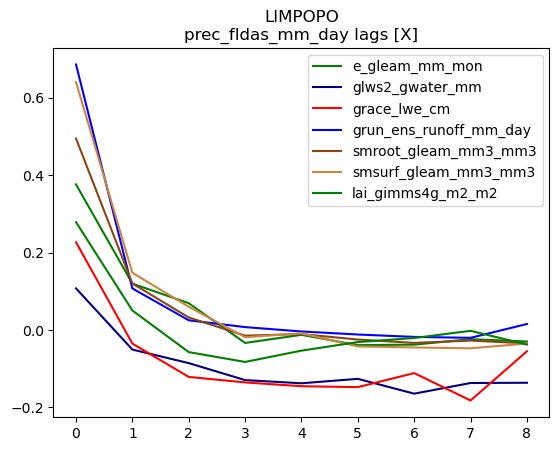

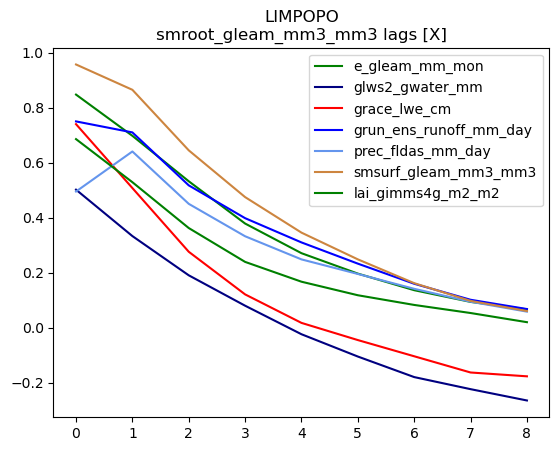

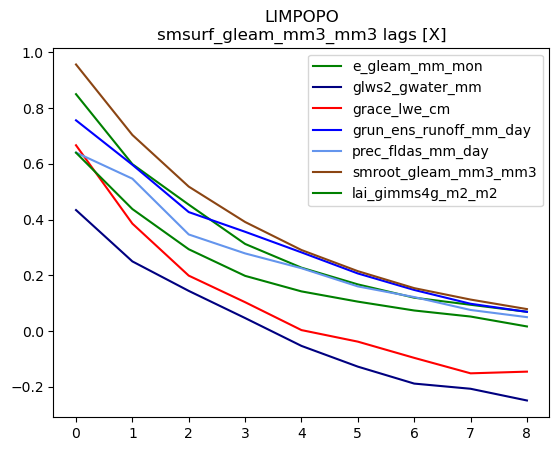

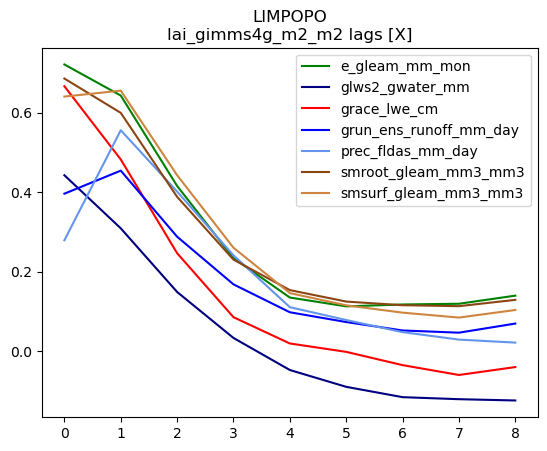

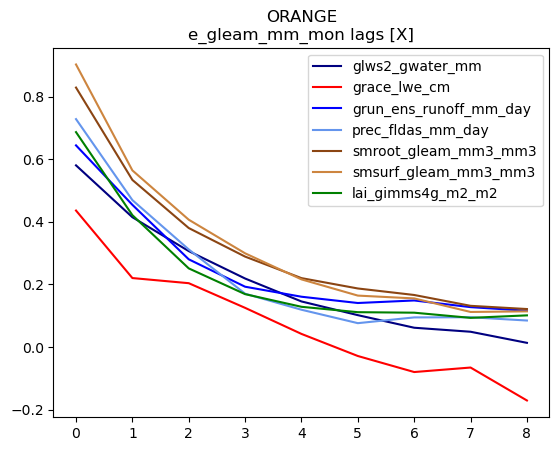

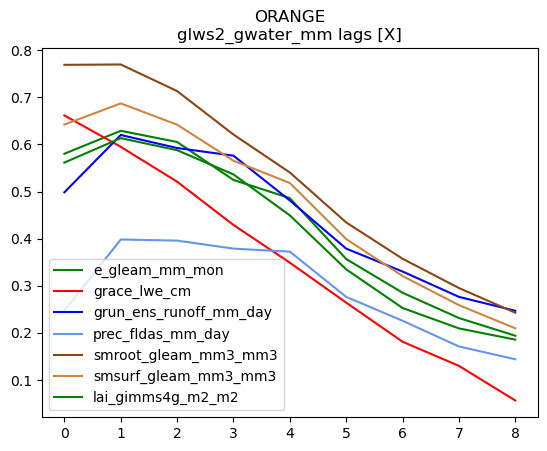

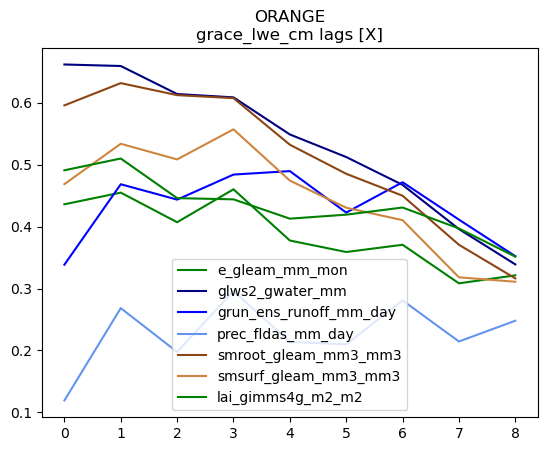

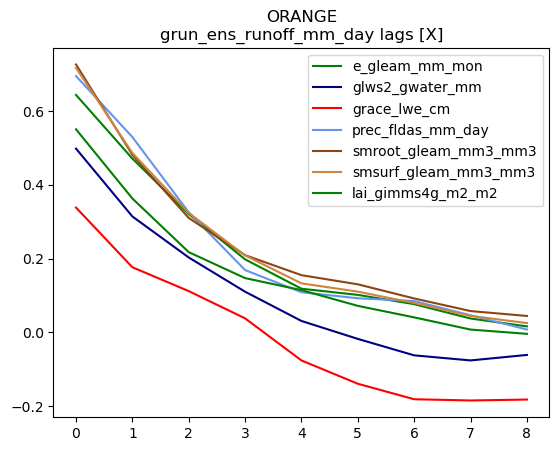

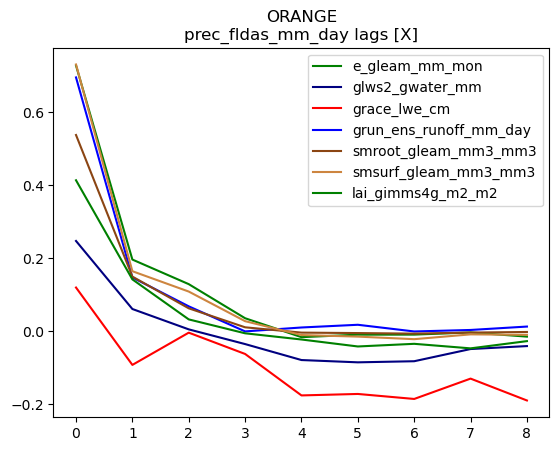

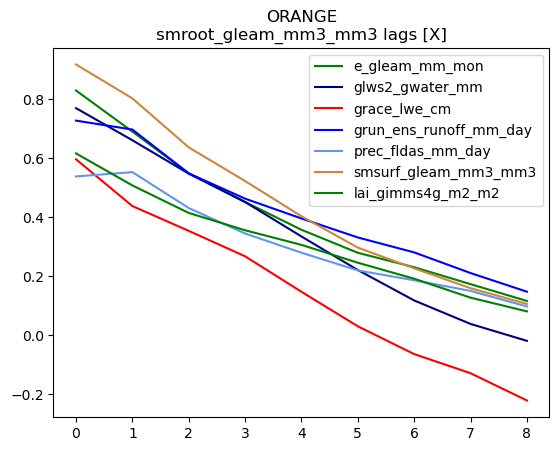

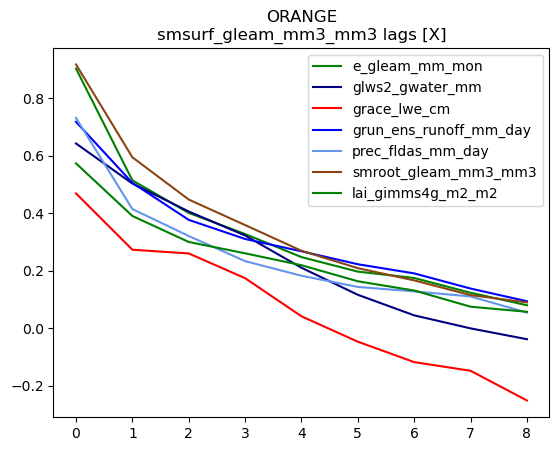

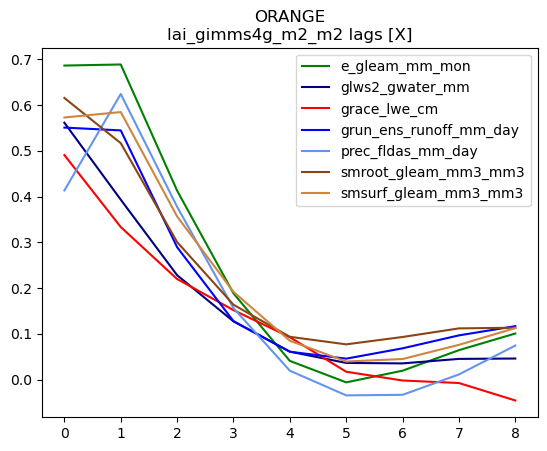

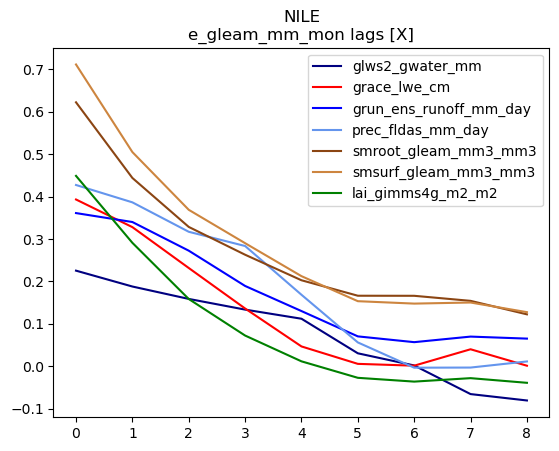

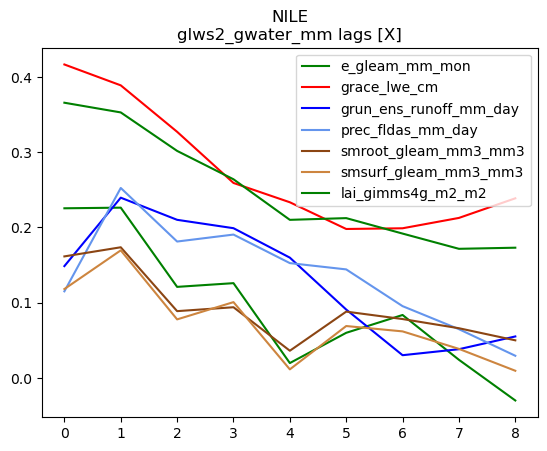

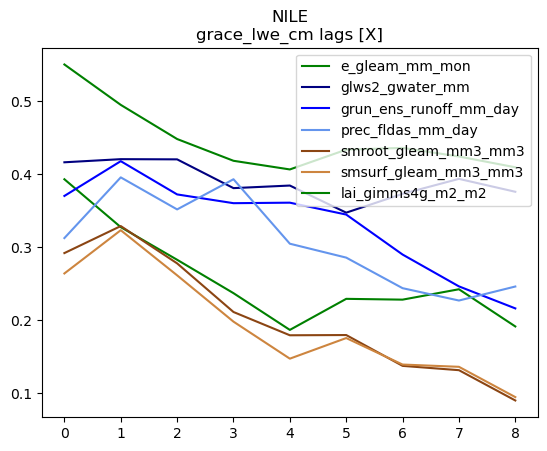

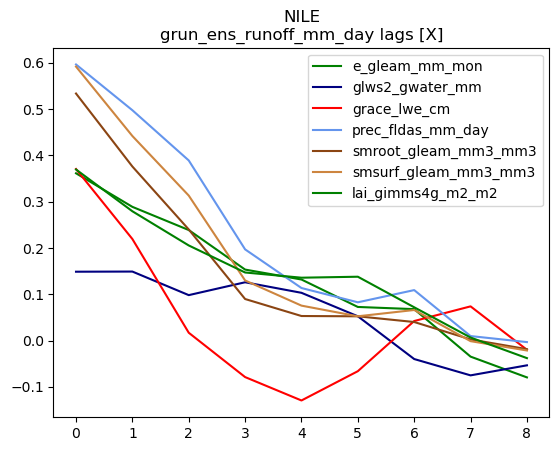

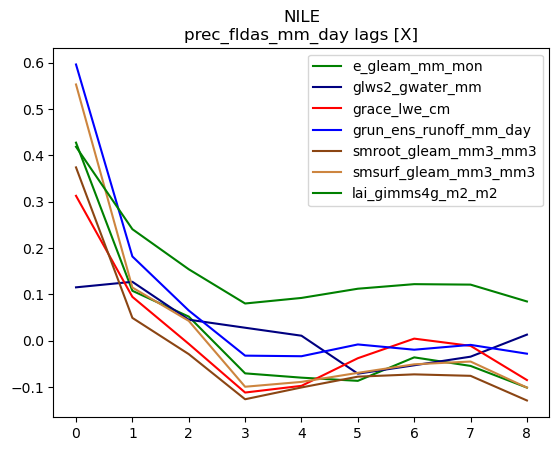

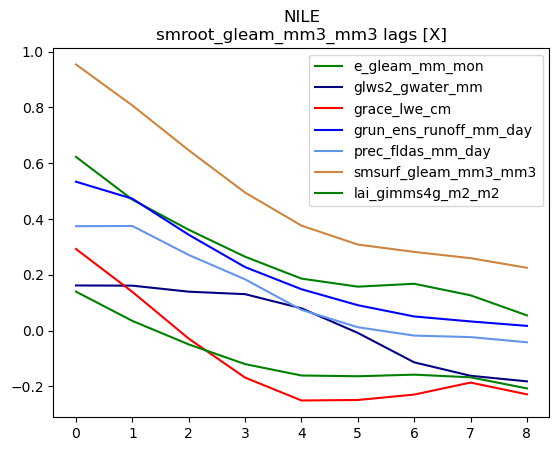

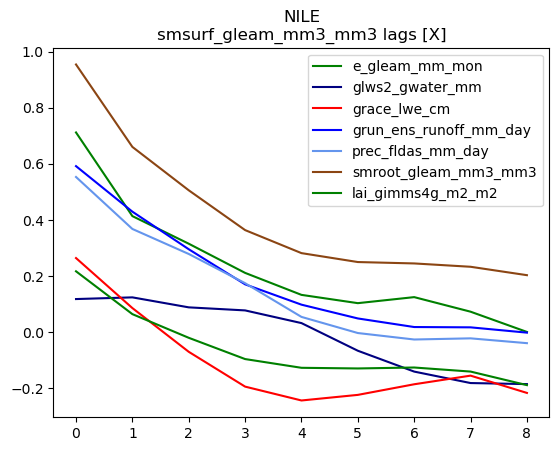

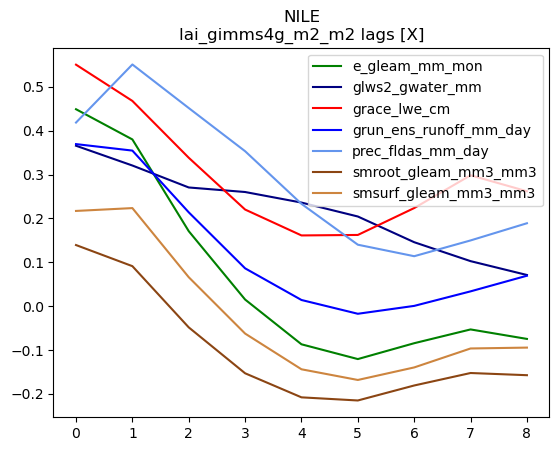

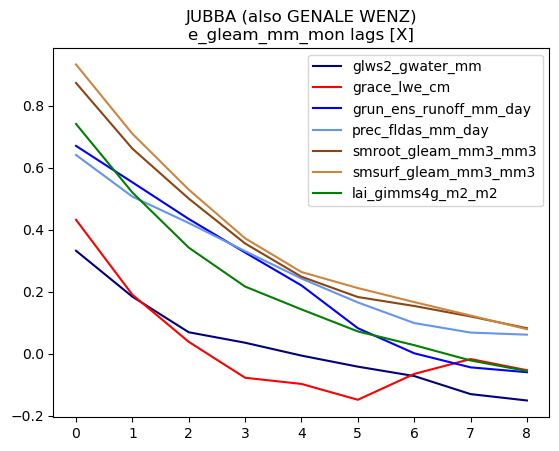

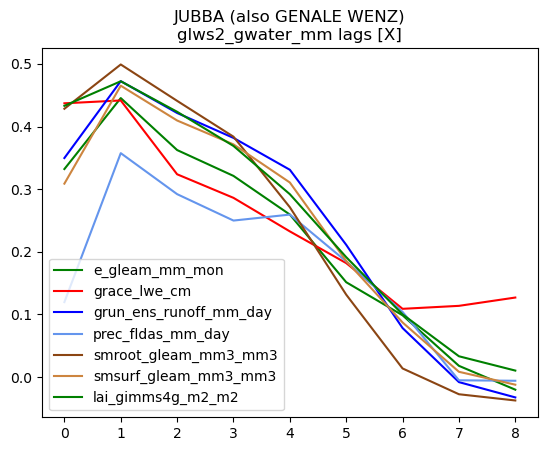

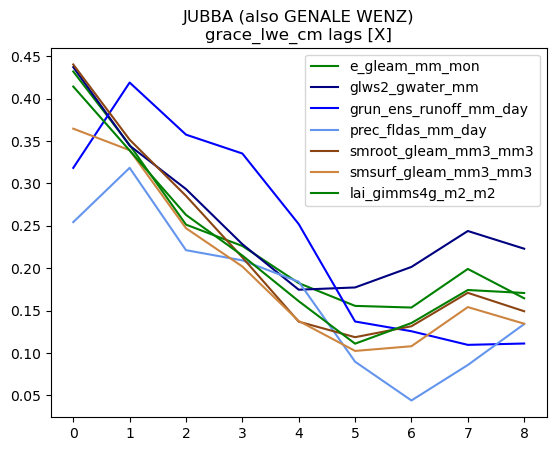

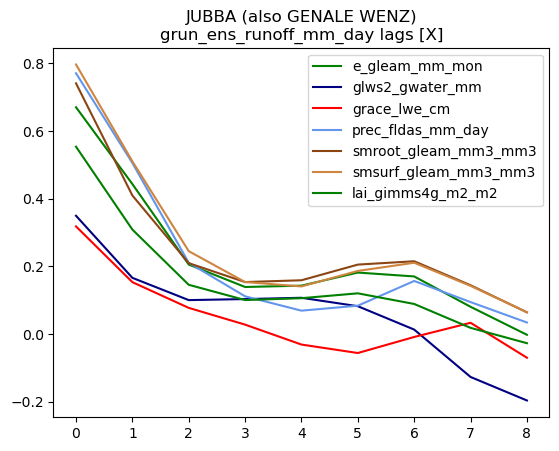

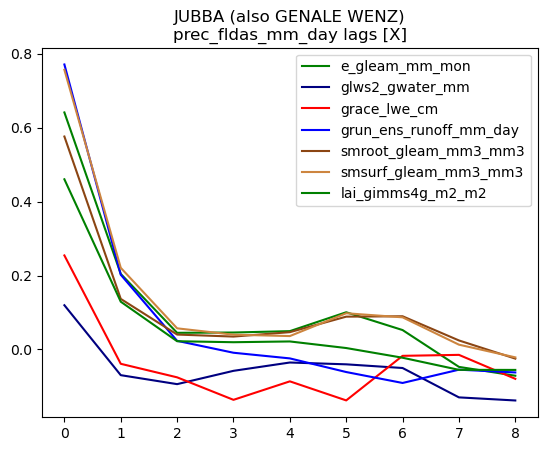

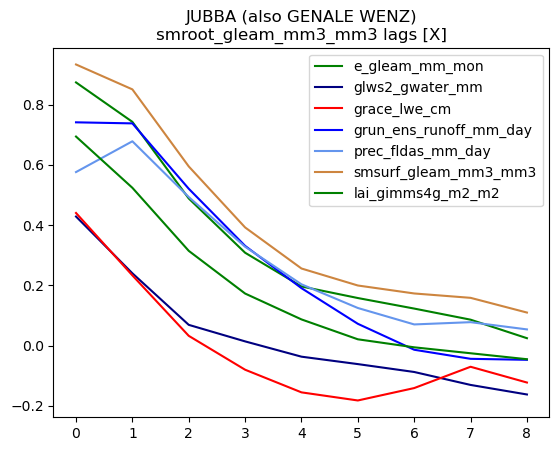

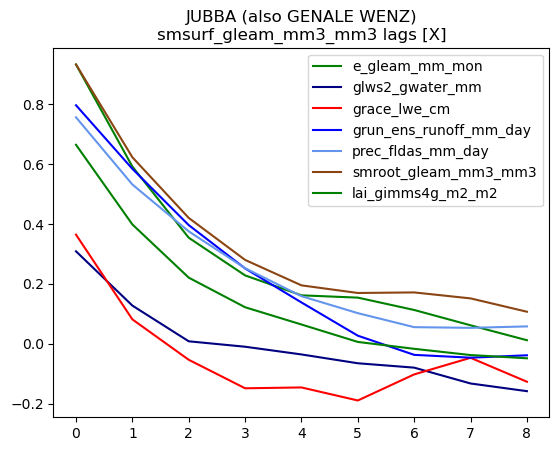

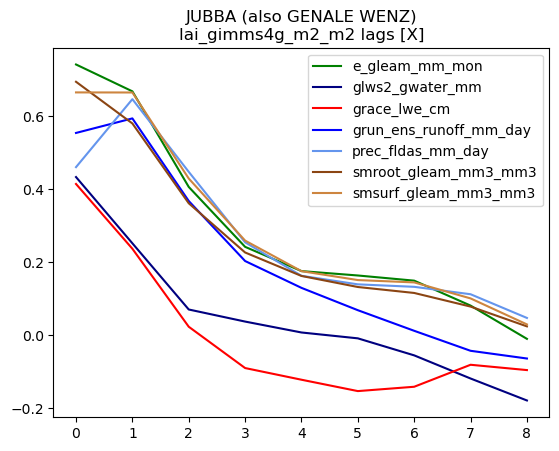

In [3]:
colors = {
'e_gleam_mm_mon':'green',
'glws2_gwater_mm':'navy',
'grace_lwe_cm':'red',
'grun_ens_runoff_mm_day':'blue',
'prec_fldas_mm_day':'cornflowerblue',
'smroot_gleam_mm3_mm3':'saddlebrown',
'smsurf_gleam_mm3_mm3':'peru',
'lai_gimms4g_m2_m2':'green'
}


for basin in basins:
    for variable in variables:
        plt.figure()
        for variable2 in variable2s:
            if variable==variable2:continue
            plt.plot(df[(df.basin==basin)&(df.var1==variable)&(df.var2==variable2)].cross_corr.values,
                     label=str(variable2),color=colors[variable2])
        plt.legend()
        plt.title(basin+'\n'+variable+' lags [X]')
        plt.savefig('./Figures/crosscorrelations_all_vars/'+variable+'_allVars_'+basin+'.png')

In [4]:
df

,basin,var1,var2,cross_corr
0,LIMPOPO,e_gleam_mm_mon,e_gleam_mm_mon,1.000000
1,LIMPOPO,e_gleam_mm_mon,e_gleam_mm_mon,0.717825
2,LIMPOPO,e_gleam_mm_mon,e_gleam_mm_mon,0.495229
3,LIMPOPO,e_gleam_mm_mon,e_gleam_mm_mon,0.363368
4,LIMPOPO,e_gleam_mm_mon,e_gleam_mm_mon,0.264730
...,...,...,...,...
2299,JUBBA (also GENALE WENZ),lai_gimms4g_m2_m2,lai_gimms4g_m2_m2,0.246703
2300,JUBBA (also GENALE WENZ),lai_gimms4g_m2_m2,lai_gimms4g_m2_m2,0.215298
2301,JUBBA (also GENALE WENZ),lai_gimms4g_m2_m2,lai_gimms4g_m2_m2,0.178214
2302,JUBBA (also GENALE WENZ),lai_gimms4g_m2_m2,lai_gimms4g_m2_m2,0.095882
